In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, losses
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### Load the data

In [2]:
(train_ds, test_ds), metadata = tfds.load('cats_vs_dogs', split=['train[:35%]', 'train[90%:95%]'],
                                          with_info=True, as_supervised=True, shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2R6W36/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
# info related to the dataset
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

### More about the data

In [4]:
tot_train_images = train_ds.__len__().numpy()
tot_test_images = test_ds.__len__().numpy()

print(f"The total number of training images is: {tot_train_images}")
print(f"The total number of test images is: {tot_test_images}")
im_iter = train_ds.__iter__()

The total number of training images is: 8142
The total number of test images is: 1163


The original shape of this image is: (262, 350, 3)


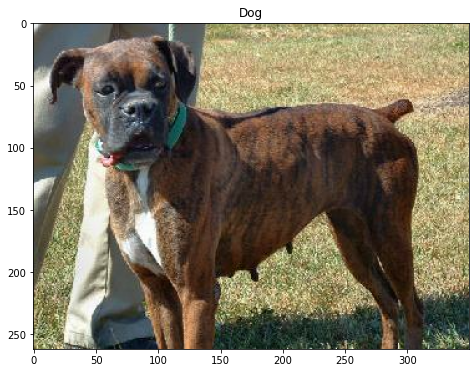

In [5]:
# visualize an image in the training dataset
image, label = next(im_iter)
plt.figure(figsize=(8,6))
label = (1-label.numpy())*"Cat" + label.numpy()*"Dog"
plt.imshow(image.numpy())
plt.title(label)
print(f"The original shape of this image is: {image.numpy().shape}")

As you can see by running multiple times the code cell above, the images in the dataset have different shapes (i.e. different number of pixels)

We need to resize the images to a common shape

### Pre-process the data

In [6]:
def image_formatting(image, label):
    # converting pixel values (uint8) to float32 type
    image = tf.cast(image, tf.float32)
    # normalizing the data to be in range of -1, +1
    image = applications.resnet_v2.preprocess_input(image)
    # resizing all images to a shape of 224x*224*3
    image = tf.image.resize(image, (224, 224))
    return image, label
    
# converting all images to same shape and formatting them for quicker training of the model
train = train_ds.map(image_formatting)
test = test_ds.map(image_formatting)

In [7]:
# suffle the data abd create batches
batch_size = 128
shuffle_size = 1000

train_batches = train.shuffle(shuffle_size).batch(batch_size)
test_batches = test.batch(batch_size)

### Create a pre-trained model

We will exploit keras.applications API to create a pre-trained model from ResNet152V2. This is a very deep convolutional neural network with ~60 million parameters that was trained using the ImageNet dataset. We will not re-train the entire network on the Cats_vs_Dog data (This would be computationally demanding). Instead, we will keep the majority of the network by replacing only the last fully connected layers with new layers that we are going to train on our data. Basically, ResNet152V2 will be used for feature extraction.

keras.applications: https://keras.io/api/applications/
ResNet152V2: https://keras.io/api/applications/resnet/#resnet152v2-function

In [8]:
# create the base model based on ResNet152V2
base_model = applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on the ImageNet dataset
    input_shape=(224, 224, 3),
    include_top=False) # do not include the classifier at the top

234553344/234545216 [==============================] - 2s 0us/step


In [9]:
model = models.Sequential()
model.add(base_model) # add the entire base_model as "first layer"

## TODO
# add a GlobalAveragePooling2D layer
model.add(layers.GlobalAveragePooling2D())

# add to the model a Dense layer with 256 neurons and ReLu activation
model.add(layers.Dense(256, activation='relu'))

# add to the model a Dense layer with 10 neurons and Softmax activation
model.add(layers.Dense(1, activation='sigmoid'))

# do not train the first layer (ResNet/base_model) of the model as it is already trained
model.layers[0].trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 58,856,449
Trainable params: 524,801
Non-trainable params: 58,331,648
_________________________________________________________________


In [11]:
## TODO
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
## TODO
# train the model for 5 epochs: use a batch size of 128 data samples
model.fit(train_batches, validation_data=test_batches, batch_size=128, epochs=5, workers=32)

Epoch 1/5
64/64 [==============================] - 123s 1s/step - loss: 0.0976 - accuracy: 0.9632 - val_loss: 0.0368 - val_accuracy: 0.9905
Epoch 2/5
64/64 [==============================] - 82s 1s/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 0.0344 - val_accuracy: 0.9905
Epoch 3/5
64/64 [==============================] - 80s 1s/step - loss: 0.0137 - accuracy: 0.9963 - val_loss: 0.0352 - val_accuracy: 0.9905
Epoch 4/5
64/64 [==============================] - 80s 1s/step - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.0346 - val_accuracy: 0.9897
Epoch 5/5
64/64 [==============================] - 79s 1s/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0353 - val_accuracy: 0.9897
